# Investigating the Multiprogramming Ability of EC2 Instances using a Cost-Benefit Analysis

<strong> Team 001 </strong>: Jason Platt, Jennifer Chien, Shuhao Chang, Yuanzhen Lin, Srishti Palani

<strong> Question </strong>: How can we get the best multiprogramming ability from EC2 instances with a fixed budget? 

Introduction: 

- Cloud Computing enhances allows us to run computations on remote computer system resources, when we want to, without having to worry about actively managing resources. However, this ability comes at a price. Cloud providers typically use a "pay-as-you-go" model, which can lead to unexpected operating expenses if programmers or administrators are not familiar with cloud-pricing models. Since we want to maximize CPU time and utility for the cost of using an EC2 instance, in this project, we investigate the multiprogramming ability of different EC2 instances using a cost-benefit analysis.

- Multi-programming Ability: 
    - One of the most important roles of an Operating System is to assign compute power to the many processes that are need to be executed. 
    - In a non-multiprogrammed system, as soon as one job leaves the CPU and goes for some other task (say I/O ), the CPU becomes idle. The CPU keeps waiting and waiting until this job (which was executing earlier) comes back and resumes its execution with the CPU. So CPU remains free for all this while. 
    - Now it has a drawback that the CPU remains idle for a very long period of time. Also, other jobs which are waiting to be executed might not get a chance to execute because the CPU is still allocated to the earlier job.
    - This poses a very serious problem that even though other jobs are ready to execute, CPU is not allocated to them as the CPU is allocated to a job which is not even utilizing it (as it is busy in I/O tasks).
    - It cannot happen that one job is using the CPU for say 1 hour while the others have been waiting in the queue for 5 hours. To avoid situations like this and come up with efficient utilization of CPU, the concept of multi programming came up.
    - The main idea of multi programming is to maximize the CPU time.
    - Multiprogramming ability can be measured by the number of processes when CPU utility reaches the maximum point. When the number of processes does not exceed this point, the CPU is not fully used. After this point, cache and memory are not large enough to support all processes and they have to frequently require disk I/O, which leads to the decrease of CPU utilization called "Thrashing". 
    - Due to various cache and memory configuration of different types of EC2 instances, they have different multiprogramming levels. We want to check the maximum multiprogramming ability of different AWS EC2 instances.

- Method: To investigate the multiprogramming ability of different EC2 instances at different costs we: 
    - (i) wrote a standard python test script that  consumes a large size of memory and CPU time. We chose to multiply a NXN matrix that consumed approximately 1GB of memory
    - (ii) wrote a driver script which keeps forking new processes with the standard test program and measure the CPU utility at the same time. 
    - (iii) compared the spot prices of EC2 instances and their multiprogramming levels
    - (iv) used python libraries to parallel matrix multiplication, to see how speedup is related to increased threads.
    - (v) run the scripts on 12 different EC2 instances chosen based on their memory capacity, number of cores, and cost. 
    - (vi) analyze the differences to conclude which one is attractive at a reasonable price. 

  




#  Data

In [2]:
import pandas as pd
import os

c52xlarge=pd.read_csv(os.getcwd()+'/Data/c52xlarge.csv')
c5xlarge=pd.read_csv(os.getcwd()+'/Data/c5xlarge.csv')
c5large=pd.read_csv(os.getcwd()+'/Data/c5large.csv')

m54xlarge=pd.read_csv(os.getcwd()+'/Data/m54xlarge.csv')
m52xlarge=pd.read_csv(os.getcwd()+'/Data/m52xlarge.csv')
m5xlarge=pd.read_csv(os.getcwd()+'/Data/m5xlarge.csv')
m5large=pd.read_csv(os.getcwd()+'/Data/m5large.csv')

r54xlarge=pd.read_csv(os.getcwd()+'/Data/r54xlarge.csv')
r52xlarge=pd.read_csv(os.getcwd()+'/Data/r52xlarge.csv')
r5xlarge=pd.read_csv(os.getcwd()+'/Data/r5xlarge.csv')
r5large=pd.read_csv(os.getcwd()+'/Data/r5large.csv')

In [34]:
c5large.head()

,size_arr,num_proc,time_avg,time_std,cpu_ut_avg,cpu_ut_std
0,1,1,0.001975,0.000489,7.500,23.848480
1,1,2,0.002731,0.000074,25.000,43.301270
2,1,4,0.005025,0.000040,47.500,48.669806
3,1,8,0.010276,0.001023,83.335,35.745241
4,1,16,0.020079,0.000243,98.335,7.257567


Text(0, 0.5, 'time_avg')

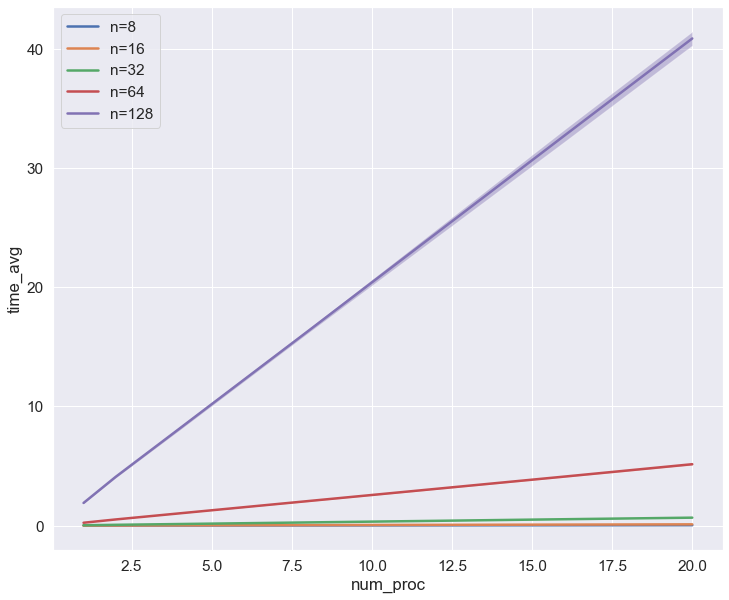

In [89]:
import seaborn as sns
import matplotlib as plt

sns.set(font_scale=1.4)
ax = c5large[c5large.size_arr == 8].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
c5large[c5large.size_arr == 16].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
c5large[c5large.size_arr == 32].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
c5large[c5large.size_arr == 64].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
c5large[c5large.size_arr == 128].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")

ax.fill_between(c5large[c5large.size_arr == 8]['num_proc'], 
                c5large[c5large.size_arr == 8]['time_avg']+2*c5large[c5large.size_arr == 8]['time_std'], 
                c5large[c5large.size_arr == 8]['time_avg']-2*c5large[c5large.size_arr == 8]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5large[c5large.size_arr == 16]['num_proc'], 
                c5large[c5large.size_arr == 16]['time_avg']+2*c5large[c5large.size_arr == 16]['time_std'], 
                c5large[c5large.size_arr == 16]['time_avg']-2*c5large[c5large.size_arr == 16]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5large[c5large.size_arr == 32]['num_proc'], 
                c5large[c5large.size_arr == 32]['time_avg']+2*c5large[c5large.size_arr == 32]['time_std'], 
                c5large[c5large.size_arr == 32]['time_avg']-2*c5large[c5large.size_arr == 32]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5large[c5large.size_arr == 64]['num_proc'], 
                c5large[c5large.size_arr == 64]['time_avg']+2*c5large[c5large.size_arr == 64]['time_std'], 
                c5large[c5large.size_arr == 64]['time_avg']-2*c5large[c5large.size_arr == 64]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5large[c5large.size_arr == 128]['num_proc'], 
                c5large[c5large.size_arr == 128]['time_avg']+2*c5large[c5large.size_arr == 128]['time_std'], 
                c5large[c5large.size_arr == 128]['time_avg']-2*c5large[c5large.size_arr == 128]['time_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("time_avg")

Text(0, 0.5, 'time_avg')

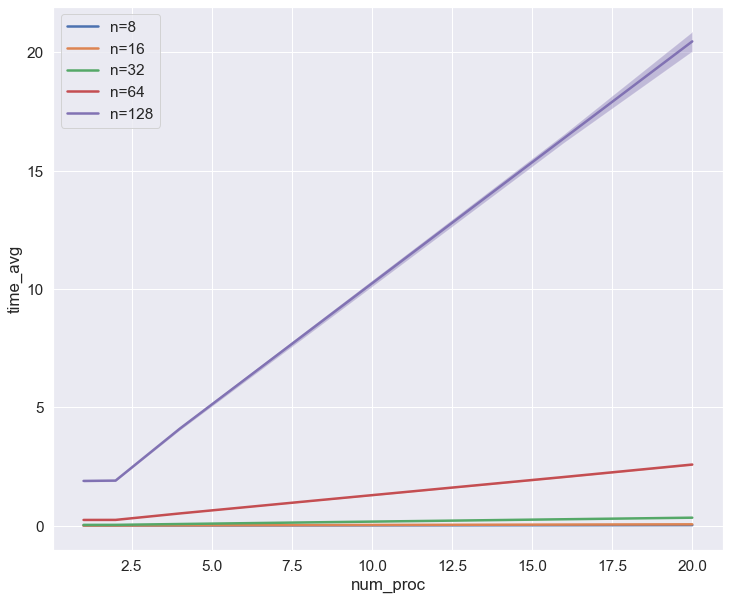

In [94]:
sns.set(font_scale=1.4)
ax = c5xlarge[c5xlarge.size_arr == 8].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
c5xlarge[c5xlarge.size_arr == 16].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
c5xlarge[c5xlarge.size_arr == 32].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
c5xlarge[c5xlarge.size_arr == 64].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
c5xlarge[c5xlarge.size_arr == 128].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")

ax.fill_between(c5xlarge[c5xlarge.size_arr == 8]['num_proc'], 
                c5xlarge[c5xlarge.size_arr == 8]['time_avg']+2*c5xlarge[c5xlarge.size_arr == 8]['time_std'], 
                c5xlarge[c5xlarge.size_arr == 8]['time_avg']-2*c5xlarge[c5xlarge.size_arr == 8]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5xlarge[c5xlarge.size_arr == 16]['num_proc'], 
                c5xlarge[c5xlarge.size_arr == 16]['time_avg']+2*c5xlarge[c5xlarge.size_arr == 16]['time_std'], 
                c5xlarge[c5xlarge.size_arr == 16]['time_avg']-2*c5xlarge[c5xlarge.size_arr == 16]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5xlarge[c5xlarge.size_arr == 32]['num_proc'], 
                c5xlarge[c5xlarge.size_arr == 32]['time_avg']+2*c5xlarge[c5xlarge.size_arr == 32]['time_std'], 
                c5xlarge[c5xlarge.size_arr == 32]['time_avg']-2*c5xlarge[c5xlarge.size_arr == 32]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5xlarge[c5xlarge.size_arr == 64]['num_proc'], 
                c5xlarge[c5xlarge.size_arr == 64]['time_avg']+2*c5xlarge[c5xlarge.size_arr == 64]['time_std'], 
                c5xlarge[c5xlarge.size_arr == 64]['time_avg']-2*c5xlarge[c5xlarge.size_arr == 64]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5xlarge[c5xlarge.size_arr == 128]['num_proc'], 
                c5xlarge[c5xlarge.size_arr == 128]['time_avg']+2*c5xlarge[c5xlarge.size_arr == 128]['time_std'], 
                c5xlarge[c5xlarge.size_arr == 128]['time_avg']-2*c5xlarge[c5xlarge.size_arr == 128]['time_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("time_avg")

Text(0, 0.5, 'time_avg')

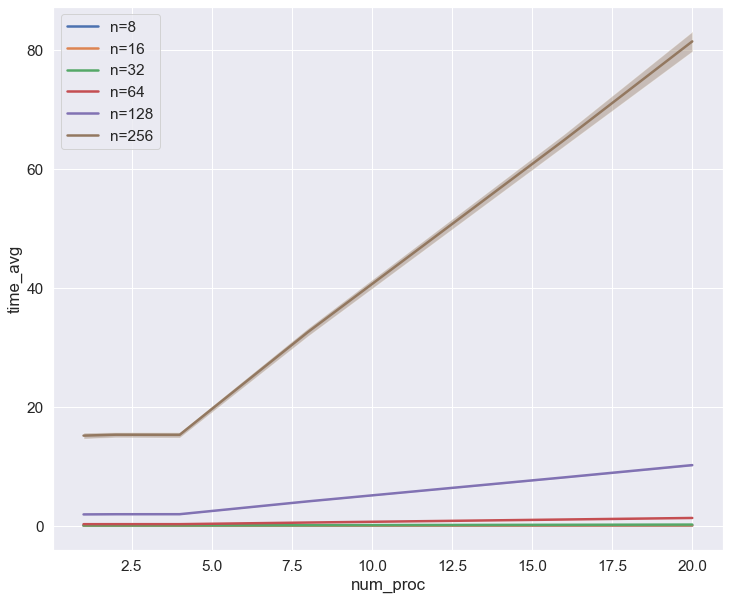

In [91]:
sns.set(font_scale=1.4)
ax = c52xlarge[c52xlarge.size_arr == 8].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
c52xlarge[c52xlarge.size_arr == 16].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
c52xlarge[c52xlarge.size_arr == 32].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
c52xlarge[c52xlarge.size_arr == 64].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
c52xlarge[c52xlarge.size_arr == 128].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")
c52xlarge[c52xlarge.size_arr == 256].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=256")

ax.fill_between(c52xlarge[c52xlarge.size_arr == 8]['num_proc'], 
                c52xlarge[c52xlarge.size_arr == 8]['time_avg']+2*c52xlarge[c52xlarge.size_arr == 8]['time_std'], 
                c52xlarge[c52xlarge.size_arr == 8]['time_avg']-2*c52xlarge[c52xlarge.size_arr == 8]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c52xlarge[c52xlarge.size_arr == 16]['num_proc'], 
                c52xlarge[c52xlarge.size_arr == 16]['time_avg']+2*c52xlarge[c52xlarge.size_arr == 16]['time_std'], 
                c52xlarge[c52xlarge.size_arr == 16]['time_avg']-2*c52xlarge[c52xlarge.size_arr == 16]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c52xlarge[c52xlarge.size_arr == 32]['num_proc'], 
                c52xlarge[c52xlarge.size_arr == 32]['time_avg']+2*c52xlarge[c52xlarge.size_arr == 32]['time_std'], 
                c52xlarge[c52xlarge.size_arr == 32]['time_avg']-2*c52xlarge[c52xlarge.size_arr == 32]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c52xlarge[c52xlarge.size_arr == 64]['num_proc'], 
                c52xlarge[c52xlarge.size_arr == 64]['time_avg']+2*c52xlarge[c52xlarge.size_arr == 64]['time_std'], 
                c52xlarge[c52xlarge.size_arr == 64]['time_avg']-2*c52xlarge[c52xlarge.size_arr == 64]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c52xlarge[c52xlarge.size_arr == 128]['num_proc'], 
                c52xlarge[c52xlarge.size_arr == 128]['time_avg']+2*c52xlarge[c52xlarge.size_arr == 128]['time_std'], 
                c52xlarge[c52xlarge.size_arr == 128]['time_avg']-2*c52xlarge[c52xlarge.size_arr == 128]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c52xlarge[c52xlarge.size_arr == 256]['num_proc'], 
                c52xlarge[c52xlarge.size_arr == 256]['time_avg']+2*c52xlarge[c52xlarge.size_arr == 256]['time_std'], 
                c52xlarge[c52xlarge.size_arr == 256]['time_avg']-2*c52xlarge[c52xlarge.size_arr == 256]['time_std'], 
                alpha = 0.4, interpolate=True)


ax.legend()
ax.set_ylabel("time_avg")

Text(0, 0.5, 'time_avg')

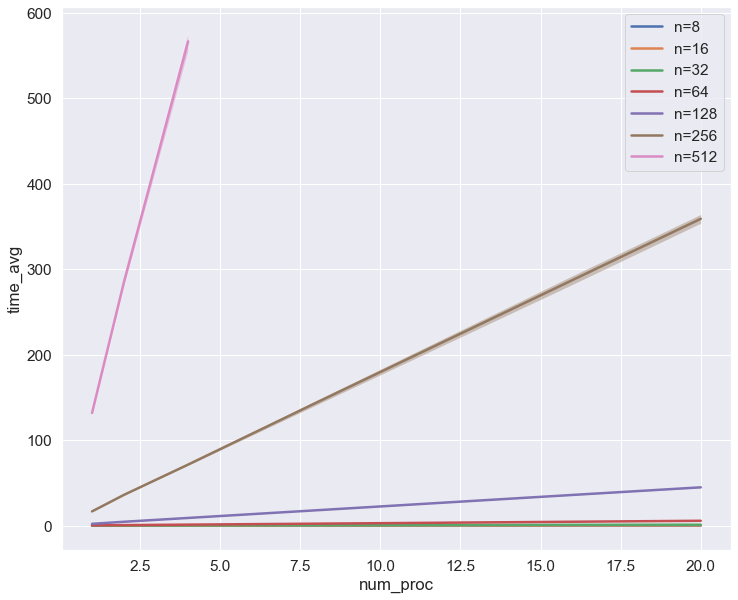

In [96]:
sns.set(font_scale=1.4)
ax = m5large[m5large.size_arr == 8].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
m5large[m5large.size_arr == 16].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
m5large[m5large.size_arr == 32].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
m5large[m5large.size_arr == 64].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
m5large[m5large.size_arr == 128].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")
m5large[m5large.size_arr == 256].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=256")
m5large[m5large.size_arr == 512].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=512")

ax.fill_between(m5large[m5large.size_arr == 8]['num_proc'], 
                m5large[m5large.size_arr == 8]['time_avg']+2*m5large[m5large.size_arr == 8]['time_std'], 
                m5large[m5large.size_arr == 8]['time_avg']-2*m5large[m5large.size_arr == 8]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5large[m5large.size_arr == 16]['num_proc'], 
                m5large[m5large.size_arr == 16]['time_avg']+2*m5large[m5large.size_arr == 16]['time_std'], 
                m5large[m5large.size_arr == 16]['time_avg']-2*m5large[m5large.size_arr == 16]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5large[m5large.size_arr == 32]['num_proc'], 
                m5large[m5large.size_arr == 32]['time_avg']+2*m5large[m5large.size_arr == 32]['time_std'], 
                m5large[m5large.size_arr == 32]['time_avg']-2*m5large[m5large.size_arr == 32]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5large[m5large.size_arr == 64]['num_proc'], 
                m5large[m5large.size_arr == 64]['time_avg']+2*m5large[m5large.size_arr == 64]['time_std'], 
                m5large[m5large.size_arr == 64]['time_avg']-2*m5large[m5large.size_arr == 64]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5large[m5large.size_arr == 128]['num_proc'], 
                m5large[m5large.size_arr == 128]['time_avg']+2*m5large[m5large.size_arr == 128]['time_std'], 
                m5large[m5large.size_arr == 128]['time_avg']-2*m5large[m5large.size_arr == 128]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5large[m5large.size_arr == 256]['num_proc'], 
                m5large[m5large.size_arr == 256]['time_avg']+2*m5large[m5large.size_arr == 256]['time_std'], 
                m5large[m5large.size_arr == 256]['time_avg']-2*m5large[m5large.size_arr == 256]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5large[m5large.size_arr == 512]['num_proc'], 
                m5large[m5large.size_arr == 512]['time_avg']+2*m5large[m5large.size_arr == 512]['time_std'], 
                m5large[m5large.size_arr == 512]['time_avg']-2*m5large[m5large.size_arr == 512]['time_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("time_avg")

Text(0, 0.5, 'time_avg')

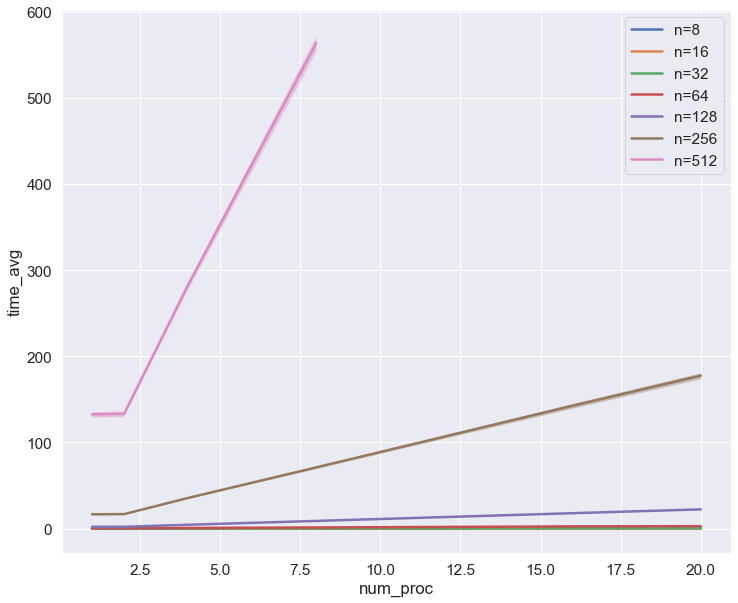

In [98]:
sns.set(font_scale=1.4)
ax = m5xlarge[m5xlarge.size_arr == 8].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
m5xlarge[m5xlarge.size_arr == 16].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
m5xlarge[m5xlarge.size_arr == 32].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
m5xlarge[m5xlarge.size_arr == 64].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
m5xlarge[m5xlarge.size_arr == 128].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")
m5xlarge[m5xlarge.size_arr == 256].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=256")
m5xlarge[m5xlarge.size_arr == 512].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=512")

ax.fill_between(m5xlarge[m5xlarge.size_arr == 8]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 8]['time_avg']+2*m5xlarge[m5xlarge.size_arr == 8]['time_std'], 
                m5xlarge[m5xlarge.size_arr == 8]['time_avg']-2*m5xlarge[m5xlarge.size_arr == 8]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5xlarge[m5xlarge.size_arr == 16]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 16]['time_avg']+2*m5xlarge[m5xlarge.size_arr == 16]['time_std'], 
                m5xlarge[m5xlarge.size_arr == 16]['time_avg']-2*m5xlarge[m5xlarge.size_arr == 16]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5xlarge[m5xlarge.size_arr == 32]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 32]['time_avg']+2*m5xlarge[m5xlarge.size_arr == 32]['time_std'], 
                m5xlarge[m5xlarge.size_arr == 32]['time_avg']-2*m5xlarge[m5xlarge.size_arr == 32]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5xlarge[m5xlarge.size_arr == 64]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 64]['time_avg']+2*m5xlarge[m5xlarge.size_arr == 64]['time_std'], 
                m5xlarge[m5xlarge.size_arr == 64]['time_avg']-2*m5xlarge[m5xlarge.size_arr == 64]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5xlarge[m5xlarge.size_arr == 128]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 128]['time_avg']+2*m5xlarge[m5xlarge.size_arr == 128]['time_std'], 
                m5xlarge[m5xlarge.size_arr == 128]['time_avg']-2*m5xlarge[m5xlarge.size_arr == 128]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5xlarge[m5xlarge.size_arr == 256]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 256]['time_avg']+2*m5xlarge[m5xlarge.size_arr == 256]['time_std'], 
                m5xlarge[m5xlarge.size_arr == 256]['time_avg']-2*m5xlarge[m5xlarge.size_arr == 256]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5xlarge[m5xlarge.size_arr == 512]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 512]['time_avg']+2*m5xlarge[m5xlarge.size_arr == 512]['time_std'], 
                m5xlarge[m5xlarge.size_arr == 512]['time_avg']-2*m5xlarge[m5xlarge.size_arr == 512]['time_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("time_avg")

Text(0, 0.5, 'time_avg')

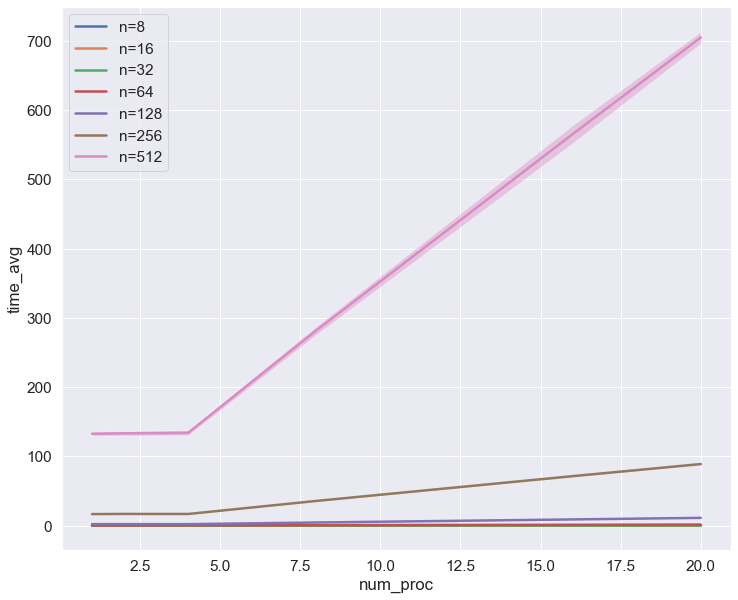

In [100]:
sns.set(font_scale=1.4)
ax = m52xlarge[m52xlarge.size_arr == 8].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
m52xlarge[m52xlarge.size_arr == 16].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
m52xlarge[m52xlarge.size_arr == 32].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
m52xlarge[m52xlarge.size_arr == 64].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
m52xlarge[m52xlarge.size_arr == 128].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")
m52xlarge[m52xlarge.size_arr == 256].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=256")
m52xlarge[m52xlarge.size_arr == 512].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=512")

ax.fill_between(m52xlarge[m52xlarge.size_arr == 8]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 8]['time_avg']+2*m52xlarge[m52xlarge.size_arr == 8]['time_std'], 
                m52xlarge[m52xlarge.size_arr == 8]['time_avg']-2*m52xlarge[m52xlarge.size_arr == 8]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m52xlarge[m52xlarge.size_arr == 16]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 16]['time_avg']+2*m52xlarge[m52xlarge.size_arr == 16]['time_std'], 
                m52xlarge[m52xlarge.size_arr == 16]['time_avg']-2*m52xlarge[m52xlarge.size_arr == 16]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m52xlarge[m52xlarge.size_arr == 32]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 32]['time_avg']+2*m52xlarge[m52xlarge.size_arr == 32]['time_std'], 
                m52xlarge[m52xlarge.size_arr == 32]['time_avg']-2*m52xlarge[m52xlarge.size_arr == 32]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m52xlarge[m52xlarge.size_arr == 64]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 64]['time_avg']+2*m52xlarge[m52xlarge.size_arr == 64]['time_std'], 
                m52xlarge[m52xlarge.size_arr == 64]['time_avg']-2*m52xlarge[m52xlarge.size_arr == 64]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m52xlarge[m52xlarge.size_arr == 128]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 128]['time_avg']+2*m52xlarge[m52xlarge.size_arr == 128]['time_std'], 
                m52xlarge[m52xlarge.size_arr == 128]['time_avg']-2*m52xlarge[m52xlarge.size_arr == 128]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m52xlarge[m52xlarge.size_arr == 256]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 256]['time_avg']+2*m52xlarge[m52xlarge.size_arr == 256]['time_std'], 
                m52xlarge[m52xlarge.size_arr == 256]['time_avg']-2*m52xlarge[m52xlarge.size_arr == 256]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m52xlarge[m52xlarge.size_arr == 512]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 512]['time_avg']+2*m52xlarge[m52xlarge.size_arr == 512]['time_std'], 
                m52xlarge[m52xlarge.size_arr == 512]['time_avg']-2*m52xlarge[m52xlarge.size_arr == 512]['time_std'], 
                alpha = 0.4, interpolate=True)


ax.legend()
ax.set_ylabel("time_avg")

Text(0, 0.5, 'time_avg')

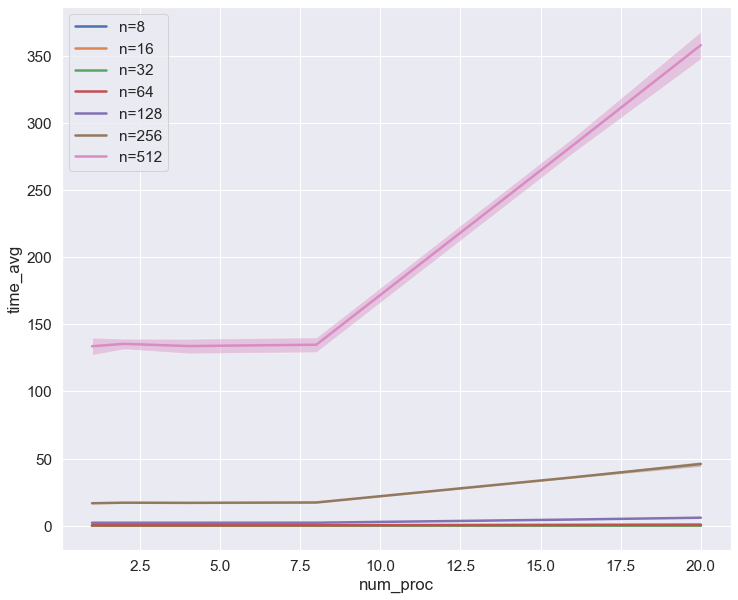

In [102]:
sns.set(font_scale=1.4)
ax = m54xlarge[m54xlarge.size_arr == 8].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
m54xlarge[m54xlarge.size_arr == 16].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
m54xlarge[m54xlarge.size_arr == 32].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
m54xlarge[m54xlarge.size_arr == 64].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
m54xlarge[m54xlarge.size_arr == 128].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")
m54xlarge[m54xlarge.size_arr == 256].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=256")
m54xlarge[m54xlarge.size_arr == 512].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=512")

ax.fill_between(m54xlarge[m54xlarge.size_arr == 8]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 8]['time_avg']+2*m54xlarge[m54xlarge.size_arr == 8]['time_std'], 
                m54xlarge[m54xlarge.size_arr == 8]['time_avg']-2*m54xlarge[m54xlarge.size_arr == 8]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 16]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 16]['time_avg']+2*m54xlarge[m54xlarge.size_arr == 16]['time_std'], 
                m54xlarge[m54xlarge.size_arr == 16]['time_avg']-2*m54xlarge[m54xlarge.size_arr == 16]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 32]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 32]['time_avg']+2*m54xlarge[m54xlarge.size_arr == 32]['time_std'], 
                m54xlarge[m54xlarge.size_arr == 32]['time_avg']-2*m54xlarge[m54xlarge.size_arr == 32]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 64]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 64]['time_avg']+2*m54xlarge[m54xlarge.size_arr == 64]['time_std'], 
                m54xlarge[m54xlarge.size_arr == 64]['time_avg']-2*m54xlarge[m54xlarge.size_arr == 64]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 128]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 128]['time_avg']+2*m54xlarge[m54xlarge.size_arr == 128]['time_std'], 
                m54xlarge[m54xlarge.size_arr == 128]['time_avg']-2*m54xlarge[m54xlarge.size_arr == 128]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 256]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 256]['time_avg']+2*m54xlarge[m54xlarge.size_arr == 256]['time_std'], 
                m54xlarge[m54xlarge.size_arr == 256]['time_avg']-2*m54xlarge[m54xlarge.size_arr == 256]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 512]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 512]['time_avg']+2*m54xlarge[m54xlarge.size_arr == 512]['time_std'], 
                m54xlarge[m54xlarge.size_arr == 512]['time_avg']-2*m54xlarge[m54xlarge.size_arr == 512]['time_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("time_avg")

Text(0, 0.5, 'time_avg')

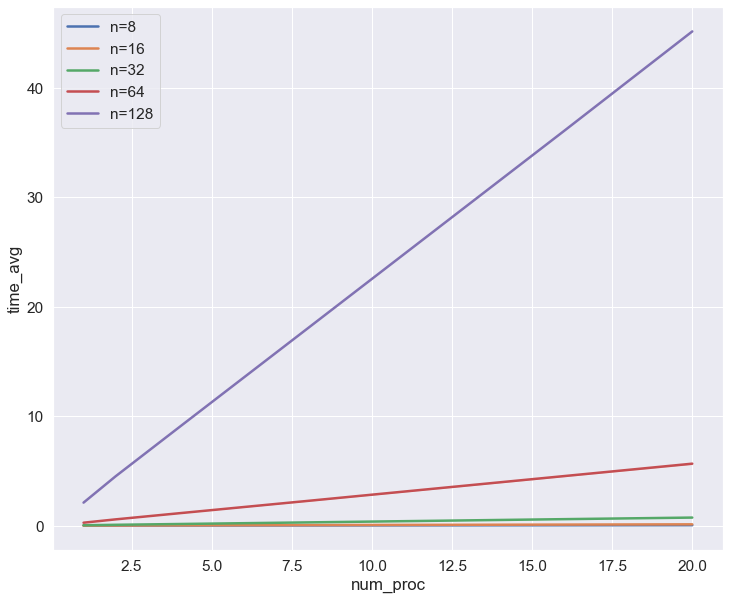

In [106]:
sns.set(font_scale=1.4)
ax = r5large[r5large.size_arr == 8].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
r5large[r5large.size_arr == 16].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
r5large[r5large.size_arr == 32].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
r5large[r5large.size_arr == 64].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")

ax.fill_between(r5large[r5large.size_arr == 8]['num_proc'], 
                r5large[r5large.size_arr == 8]['time_avg']+2*r5large[r5large.size_arr == 8]['time_std'], 
                r5large[r5large.size_arr == 8]['time_avg']-2*r5large[r5large.size_arr == 8]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5large[r5large.size_arr == 16]['num_proc'], 
                r5large[r5large.size_arr == 16]['time_avg']+2*r5large[r5large.size_arr == 16]['time_std'], 
                r5large[r5large.size_arr == 16]['time_avg']-2*r5large[r5large.size_arr == 16]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5large[r5large.size_arr == 32]['num_proc'], 
                r5large[r5large.size_arr == 32]['time_avg']+2*r5large[r5large.size_arr == 32]['time_std'], 
                r5large[r5large.size_arr == 32]['time_avg']-2*r5large[r5large.size_arr == 32]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5large[r5large.size_arr == 64]['num_proc'], 
                r5large[r5large.size_arr == 64]['time_avg']+2*r5large[r5large.size_arr == 64]['time_std'], 
                r5large[r5large.size_arr == 64]['time_avg']-2*r5large[r5large.size_arr == 64]['time_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("time_avg")

Text(0, 0.5, 'time_avg')

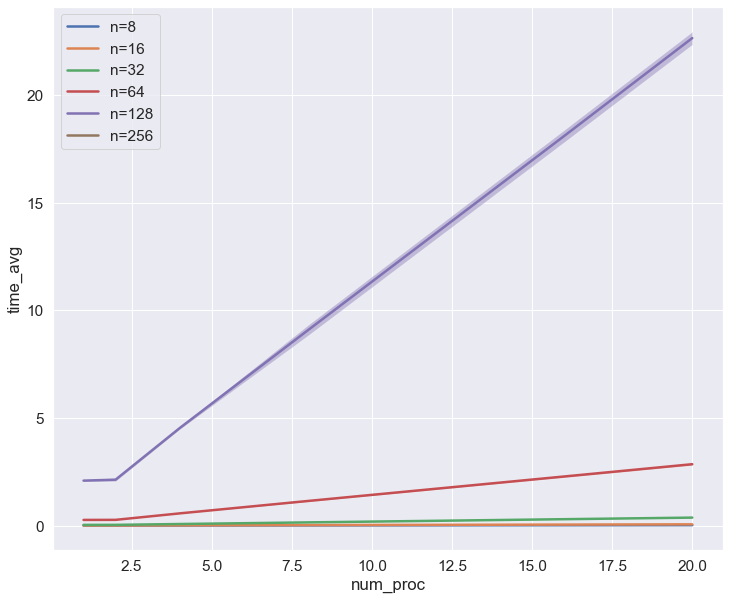

In [111]:
sns.set(font_scale=1.4)
ax = r5xlarge[r5xlarge.size_arr == 8].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
r5xlarge[r5xlarge.size_arr == 16].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
r5xlarge[r5xlarge.size_arr == 32].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
r5xlarge[r5xlarge.size_arr == 64].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
r5xlarge[r5xlarge.size_arr == 128].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")

ax.fill_between(r5xlarge[r5xlarge.size_arr == 8]['num_proc'], 
                r5xlarge[r5xlarge.size_arr == 8]['time_avg']+2*r5xlarge[r5xlarge.size_arr == 8]['time_std'], 
                r5xlarge[r5xlarge.size_arr == 8]['time_avg']-2*r5xlarge[r5xlarge.size_arr == 8]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5xlarge[r5xlarge.size_arr == 16]['num_proc'], 
                r5xlarge[r5xlarge.size_arr == 16]['time_avg']+2*r5xlarge[r5xlarge.size_arr == 16]['time_std'], 
                r5xlarge[r5xlarge.size_arr == 16]['time_avg']-2*r5xlarge[r5xlarge.size_arr == 16]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5xlarge[r5xlarge.size_arr == 32]['num_proc'], 
                r5xlarge[r5xlarge.size_arr == 32]['time_avg']+2*r5xlarge[r5xlarge.size_arr == 32]['time_std'], 
                r5xlarge[r5xlarge.size_arr == 32]['time_avg']-2*r5xlarge[r5xlarge.size_arr == 32]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5xlarge[r5xlarge.size_arr == 64]['num_proc'], 
                r5xlarge[r5xlarge.size_arr == 64]['time_avg']+2*r5xlarge[r5xlarge.size_arr == 64]['time_std'], 
                r5xlarge[r5xlarge.size_arr == 64]['time_avg']-2*r5xlarge[r5xlarge.size_arr == 64]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5xlarge[r5xlarge.size_arr == 128]['num_proc'], 
                r5xlarge[r5xlarge.size_arr == 128]['time_avg']+2*r5xlarge[r5xlarge.size_arr == 128]['time_std'], 
                r5xlarge[r5xlarge.size_arr == 128]['time_avg']-2*r5xlarge[r5xlarge.size_arr == 128]['time_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("time_avg")

Text(0, 0.5, 'time_avg')

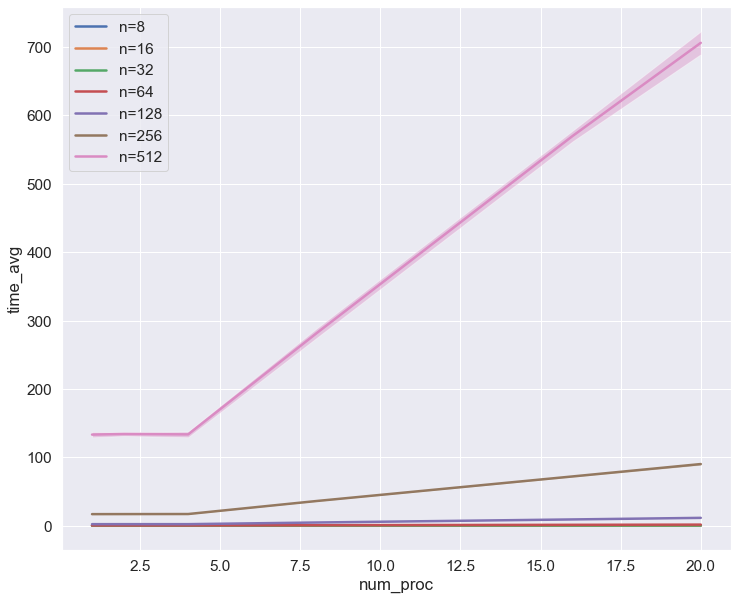

In [113]:
sns.set(font_scale=1.4)
ax = r52xlarge[r52xlarge.size_arr == 8].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
r52xlarge[r52xlarge.size_arr == 16].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
r52xlarge[r52xlarge.size_arr == 32].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
r52xlarge[r52xlarge.size_arr == 64].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
r52xlarge[r52xlarge.size_arr == 128].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")
r52xlarge[r52xlarge.size_arr == 256].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=256")
r52xlarge[r52xlarge.size_arr == 512].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=512")

ax.fill_between(r52xlarge[r52xlarge.size_arr == 8]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 8]['time_avg']+2*r52xlarge[r52xlarge.size_arr == 8]['time_std'], 
                r52xlarge[r52xlarge.size_arr == 8]['time_avg']-2*r52xlarge[r52xlarge.size_arr == 8]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r52xlarge[r52xlarge.size_arr == 16]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 16]['time_avg']+2*r52xlarge[r52xlarge.size_arr == 16]['time_std'], 
                r52xlarge[r52xlarge.size_arr == 16]['time_avg']-2*r52xlarge[r52xlarge.size_arr == 16]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r52xlarge[r52xlarge.size_arr == 32]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 32]['time_avg']+2*r52xlarge[r52xlarge.size_arr == 32]['time_std'], 
                r52xlarge[r52xlarge.size_arr == 32]['time_avg']-2*r52xlarge[r52xlarge.size_arr == 32]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r52xlarge[r52xlarge.size_arr == 64]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 64]['time_avg']+2*r52xlarge[r52xlarge.size_arr == 64]['time_std'], 
                r52xlarge[r52xlarge.size_arr == 64]['time_avg']-2*r52xlarge[r52xlarge.size_arr == 64]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r52xlarge[r52xlarge.size_arr == 128]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 128]['time_avg']+2*r52xlarge[r52xlarge.size_arr == 128]['time_std'], 
                r52xlarge[r52xlarge.size_arr == 128]['time_avg']-2*r52xlarge[r52xlarge.size_arr == 128]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r52xlarge[r52xlarge.size_arr == 256]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 256]['time_avg']+2*r52xlarge[r52xlarge.size_arr == 256]['time_std'], 
                r52xlarge[r52xlarge.size_arr == 256]['time_avg']-2*r52xlarge[r52xlarge.size_arr == 256]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r52xlarge[r52xlarge.size_arr == 512]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 512]['time_avg']+2*r52xlarge[r52xlarge.size_arr == 512]['time_std'], 
                r52xlarge[r52xlarge.size_arr == 512]['time_avg']-2*r52xlarge[r52xlarge.size_arr == 512]['time_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("time_avg")

Text(0, 0.5, 'time_avg')

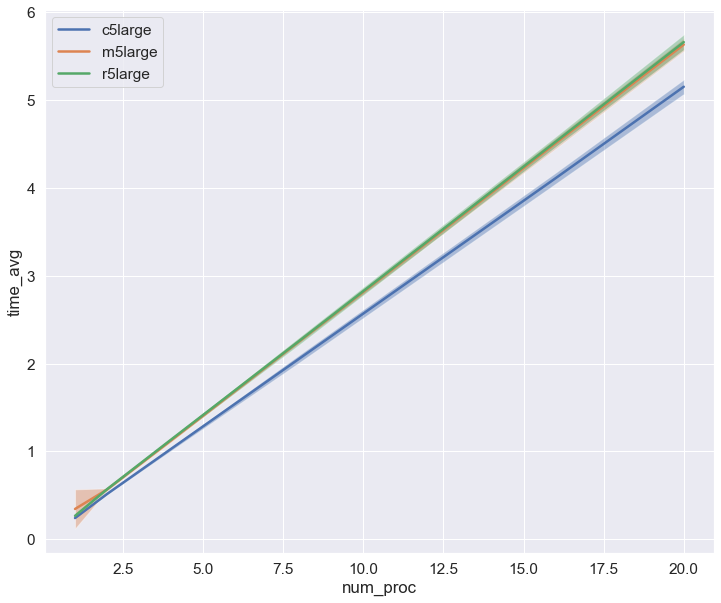

In [8]:
import seaborn as sns
import matplotlib as plt

sns.set(font_scale=1.4)
ax = c5large[c5large.size_arr == 64].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="c5large")
m5large[m5large.size_arr == 64].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="m5large")
r5large[r5large.size_arr == 64].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="r5large")

ax.fill_between(c5large[c5large.size_arr == 64]['num_proc'], 
                c5large[c5large.size_arr == 64]['time_avg']+2*c5large[c5large.size_arr == 64]['time_std'], 
                c5large[c5large.size_arr == 64]['time_avg']-2*c5large[c5large.size_arr == 64]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5large[m5large.size_arr == 64]['num_proc'], 
                m5large[m5large.size_arr == 64]['time_avg']+2*m5large[m5large.size_arr == 64]['time_std'], 
                m5large[m5large.size_arr == 64]['time_avg']-2*m5large[m5large.size_arr == 64]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5large[r5large.size_arr == 64]['num_proc'], 
                r5large[r5large.size_arr == 64]['time_avg']+2*r5large[r5large.size_arr == 64]['time_std'], 
                r5large[r5large.size_arr == 64]['time_avg']-2*r5large[r5large.size_arr == 64]['time_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("time_avg")

Text(0, 0.5, 'time_avg')

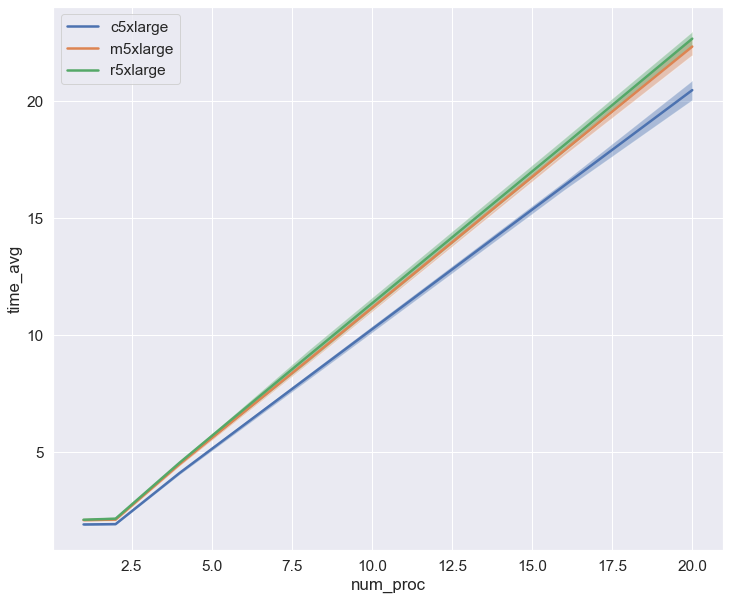

In [9]:
sns.set(font_scale=1.4)
ax = c5xlarge[c5xlarge.size_arr == 128].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="c5xlarge")
m5xlarge[m5xlarge.size_arr == 128].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="m5xlarge")
r5xlarge[r5xlarge.size_arr == 128].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="r5xlarge")

ax.fill_between(c5xlarge[c5xlarge.size_arr == 128]['num_proc'], 
                c5xlarge[c5xlarge.size_arr == 128]['time_avg']+2*c5xlarge[c5xlarge.size_arr == 128]['time_std'], 
                c5xlarge[c5xlarge.size_arr == 128]['time_avg']-2*c5xlarge[c5xlarge.size_arr == 128]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5xlarge[m5xlarge.size_arr == 128]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 128]['time_avg']+2*m5xlarge[m5xlarge.size_arr == 128]['time_std'], 
                m5xlarge[m5xlarge.size_arr == 128]['time_avg']-2*m5xlarge[m5xlarge.size_arr == 128]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5xlarge[r5xlarge.size_arr == 128]['num_proc'], 
                r5xlarge[r5xlarge.size_arr == 128]['time_avg']+2*r5xlarge[r5xlarge.size_arr == 128]['time_std'], 
                r5xlarge[r5xlarge.size_arr == 128]['time_avg']-2*r5xlarge[r5xlarge.size_arr == 128]['time_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("time_avg")

Text(0, 0.5, 'time_avg')

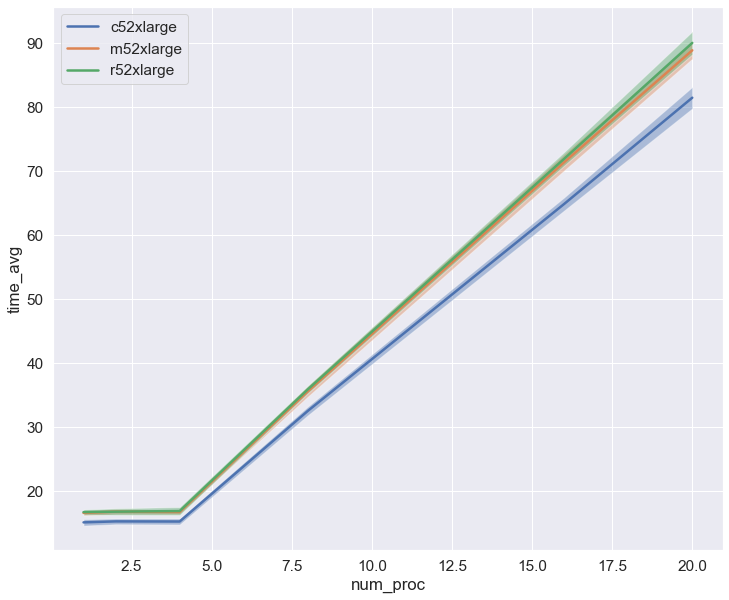

In [12]:
sns.set(font_scale=1.4)
ax = c52xlarge[c52xlarge.size_arr == 256].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="c52xlarge")
m52xlarge[m52xlarge.size_arr == 256].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="m52xlarge")
r52xlarge[r52xlarge.size_arr == 256].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="r52xlarge")

ax.fill_between(c52xlarge[c52xlarge.size_arr == 256]['num_proc'], 
                c52xlarge[c52xlarge.size_arr == 256]['time_avg']+2*c52xlarge[c52xlarge.size_arr == 256]['time_std'], 
                c52xlarge[c52xlarge.size_arr == 256]['time_avg']-2*c52xlarge[c52xlarge.size_arr == 256]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m52xlarge[m52xlarge.size_arr == 256]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 256]['time_avg']+2*m52xlarge[m52xlarge.size_arr == 256]['time_std'], 
                m52xlarge[m52xlarge.size_arr == 256]['time_avg']-2*m52xlarge[m52xlarge.size_arr == 256]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r52xlarge[r52xlarge.size_arr == 256]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 256]['time_avg']+2*r52xlarge[r52xlarge.size_arr == 256]['time_std'], 
                r52xlarge[r52xlarge.size_arr == 256]['time_avg']-2*r52xlarge[r52xlarge.size_arr == 256]['time_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("time_avg")

Text(0, 0.5, 'cpu_ut_avg')

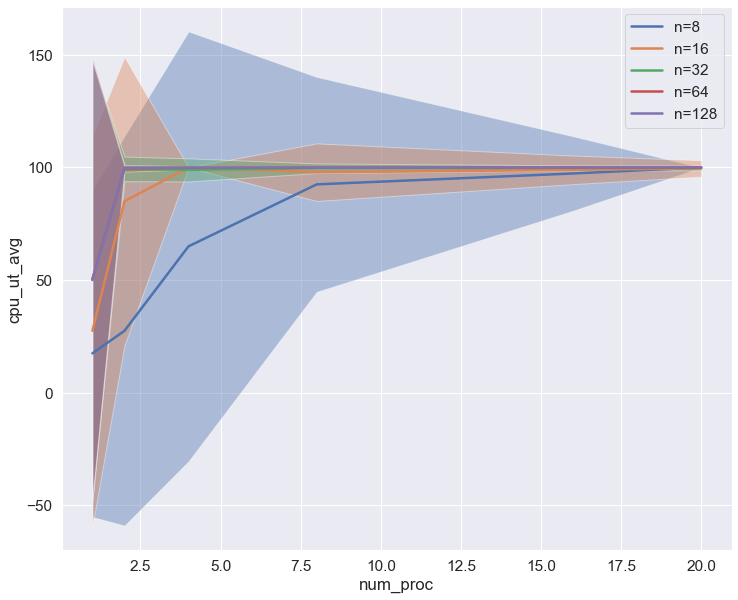

In [13]:
import seaborn as sns
import matplotlib as plt

sns.set(font_scale=1.4)
ax = c5large[c5large.size_arr == 8].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
c5large[c5large.size_arr == 16].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
c5large[c5large.size_arr == 32].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
c5large[c5large.size_arr == 64].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
c5large[c5large.size_arr == 128].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")

ax.fill_between(c5large[c5large.size_arr == 8]['num_proc'], 
                c5large[c5large.size_arr == 8]['cpu_ut_avg']+2*c5large[c5large.size_arr == 8]['cpu_ut_std'], 
                c5large[c5large.size_arr == 8]['cpu_ut_avg']-2*c5large[c5large.size_arr == 8]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5large[c5large.size_arr == 16]['num_proc'], 
                c5large[c5large.size_arr == 16]['cpu_ut_avg']+2*c5large[c5large.size_arr == 16]['cpu_ut_std'], 
                c5large[c5large.size_arr == 16]['cpu_ut_avg']-2*c5large[c5large.size_arr == 16]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5large[c5large.size_arr == 32]['num_proc'], 
                c5large[c5large.size_arr == 32]['cpu_ut_avg']+2*c5large[c5large.size_arr == 32]['cpu_ut_std'], 
                c5large[c5large.size_arr == 32]['cpu_ut_avg']-2*c5large[c5large.size_arr == 32]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5large[c5large.size_arr == 64]['num_proc'], 
                c5large[c5large.size_arr == 64]['cpu_ut_avg']+2*c5large[c5large.size_arr == 64]['cpu_ut_std'], 
                c5large[c5large.size_arr == 64]['cpu_ut_avg']-2*c5large[c5large.size_arr == 64]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5large[c5large.size_arr == 128]['num_proc'], 
                c5large[c5large.size_arr == 128]['cpu_ut_avg']+2*c5large[c5large.size_arr == 128]['cpu_ut_std'], 
                c5large[c5large.size_arr == 128]['cpu_ut_avg']-2*c5large[c5large.size_arr == 128]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("cpu_ut_avg")

Text(0, 0.5, 'cpu_ut_std')

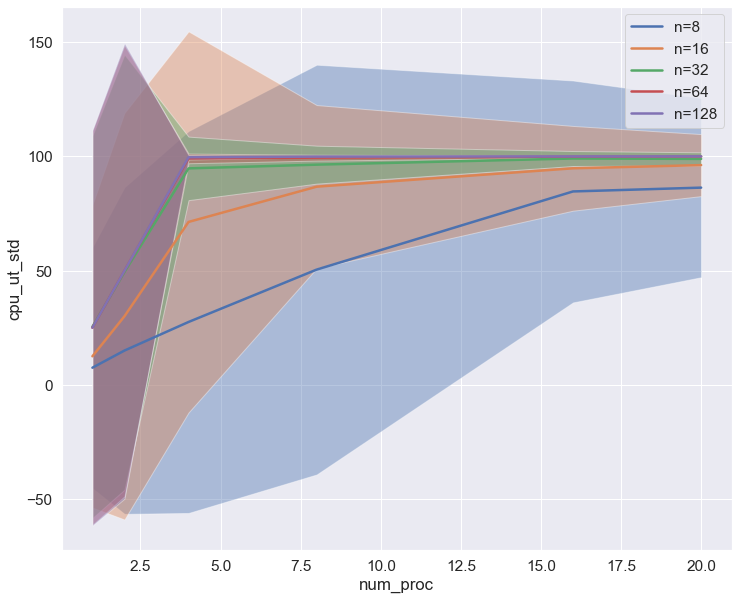

In [15]:
sns.set(font_scale=1.4)
ax = c5xlarge[c5xlarge.size_arr == 8].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
c5xlarge[c5xlarge.size_arr == 16].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
c5xlarge[c5xlarge.size_arr == 32].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
c5xlarge[c5xlarge.size_arr == 64].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
c5xlarge[c5xlarge.size_arr == 128].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")

ax.fill_between(c5xlarge[c5xlarge.size_arr == 8]['num_proc'], 
                c5xlarge[c5xlarge.size_arr == 8]['cpu_ut_avg']+2*c5xlarge[c5xlarge.size_arr == 8]['cpu_ut_std'], 
                c5xlarge[c5xlarge.size_arr == 8]['cpu_ut_avg']-2*c5xlarge[c5xlarge.size_arr == 8]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5xlarge[c5xlarge.size_arr == 16]['num_proc'], 
                c5xlarge[c5xlarge.size_arr == 16]['cpu_ut_avg']+2*c5xlarge[c5xlarge.size_arr == 16]['cpu_ut_std'], 
                c5xlarge[c5xlarge.size_arr == 16]['cpu_ut_avg']-2*c5xlarge[c5xlarge.size_arr == 16]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5xlarge[c5xlarge.size_arr == 32]['num_proc'], 
                c5xlarge[c5xlarge.size_arr == 32]['cpu_ut_avg']+2*c5xlarge[c5xlarge.size_arr == 32]['cpu_ut_std'], 
                c5xlarge[c5xlarge.size_arr == 32]['cpu_ut_avg']-2*c5xlarge[c5xlarge.size_arr == 32]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5xlarge[c5xlarge.size_arr == 64]['num_proc'], 
                c5xlarge[c5xlarge.size_arr == 64]['cpu_ut_avg']+2*c5xlarge[c5xlarge.size_arr == 64]['cpu_ut_std'], 
                c5xlarge[c5xlarge.size_arr == 64]['cpu_ut_avg']-2*c5xlarge[c5xlarge.size_arr == 64]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c5xlarge[c5xlarge.size_arr == 128]['num_proc'], 
                c5xlarge[c5xlarge.size_arr == 128]['cpu_ut_avg']+2*c5xlarge[c5xlarge.size_arr == 128]['cpu_ut_std'], 
                c5xlarge[c5xlarge.size_arr == 128]['cpu_ut_avg']-2*c5xlarge[c5xlarge.size_arr == 128]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("cpu_ut_std")

Text(0, 0.5, 'cpu_ut_avg')

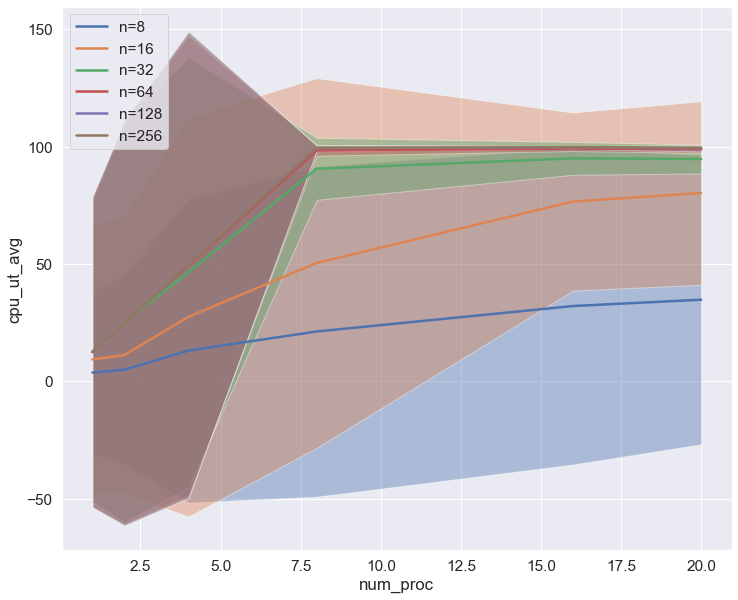

In [16]:
sns.set(font_scale=1.4)
ax = c52xlarge[c52xlarge.size_arr == 8].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
c52xlarge[c52xlarge.size_arr == 16].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
c52xlarge[c52xlarge.size_arr == 32].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
c52xlarge[c52xlarge.size_arr == 64].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
c52xlarge[c52xlarge.size_arr == 128].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")
c52xlarge[c52xlarge.size_arr == 256].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=256")

ax.fill_between(c52xlarge[c52xlarge.size_arr == 8]['num_proc'], 
                c52xlarge[c52xlarge.size_arr == 8]['cpu_ut_avg']+2*c52xlarge[c52xlarge.size_arr == 8]['cpu_ut_std'], 
                c52xlarge[c52xlarge.size_arr == 8]['cpu_ut_avg']-2*c52xlarge[c52xlarge.size_arr == 8]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c52xlarge[c52xlarge.size_arr == 16]['num_proc'], 
                c52xlarge[c52xlarge.size_arr == 16]['cpu_ut_avg']+2*c52xlarge[c52xlarge.size_arr == 16]['cpu_ut_std'], 
                c52xlarge[c52xlarge.size_arr == 16]['cpu_ut_avg']-2*c52xlarge[c52xlarge.size_arr == 16]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c52xlarge[c52xlarge.size_arr == 32]['num_proc'], 
                c52xlarge[c52xlarge.size_arr == 32]['cpu_ut_avg']+2*c52xlarge[c52xlarge.size_arr == 32]['cpu_ut_std'], 
                c52xlarge[c52xlarge.size_arr == 32]['cpu_ut_avg']-2*c52xlarge[c52xlarge.size_arr == 32]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c52xlarge[c52xlarge.size_arr == 64]['num_proc'], 
                c52xlarge[c52xlarge.size_arr == 64]['cpu_ut_avg']+2*c52xlarge[c52xlarge.size_arr == 64]['cpu_ut_std'], 
                c52xlarge[c52xlarge.size_arr == 64]['cpu_ut_avg']-2*c52xlarge[c52xlarge.size_arr == 64]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c52xlarge[c52xlarge.size_arr == 128]['num_proc'], 
                c52xlarge[c52xlarge.size_arr == 128]['cpu_ut_avg']+2*c52xlarge[c52xlarge.size_arr == 128]['cpu_ut_std'], 
                c52xlarge[c52xlarge.size_arr == 128]['cpu_ut_avg']-2*c52xlarge[c52xlarge.size_arr == 128]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(c52xlarge[c52xlarge.size_arr == 256]['num_proc'], 
                c52xlarge[c52xlarge.size_arr == 256]['cpu_ut_avg']+2*c52xlarge[c52xlarge.size_arr == 256]['cpu_ut_std'], 
                c52xlarge[c52xlarge.size_arr == 256]['cpu_ut_avg']-2*c52xlarge[c52xlarge.size_arr == 256]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)


ax.legend()
ax.set_ylabel("cpu_ut_avg")

Text(0, 0.5, 'cpu_ut_avg')

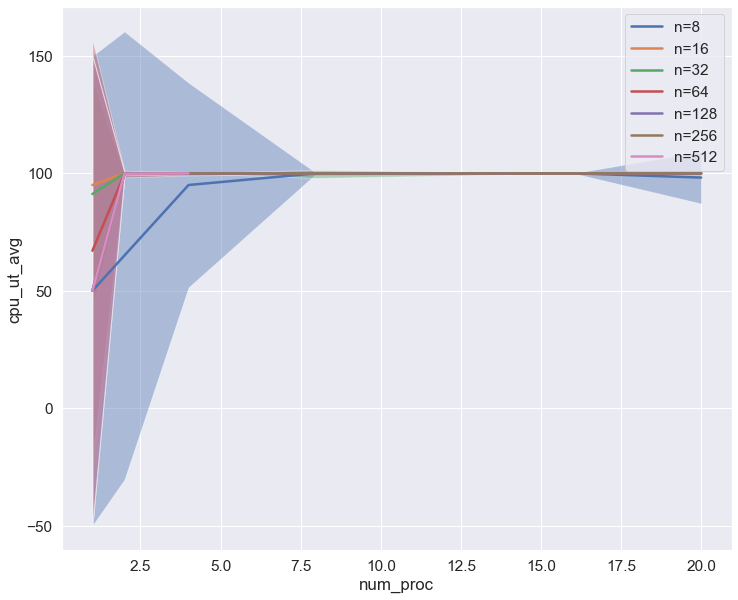

In [18]:
sns.set(font_scale=1.4)
ax = m5large[m5large.size_arr == 8].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
m5large[m5large.size_arr == 16].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
m5large[m5large.size_arr == 32].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
m5large[m5large.size_arr == 64].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
m5large[m5large.size_arr == 128].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")
m5large[m5large.size_arr == 256].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=256")
m5large[m5large.size_arr == 512].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=512")

ax.fill_between(m5large[m5large.size_arr == 8]['num_proc'], 
                m5large[m5large.size_arr == 8]['cpu_ut_avg']+2*m5large[m5large.size_arr == 8]['cpu_ut_std'], 
                m5large[m5large.size_arr == 8]['cpu_ut_avg']-2*m5large[m5large.size_arr == 8]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5large[m5large.size_arr == 16]['num_proc'], 
                m5large[m5large.size_arr == 16]['cpu_ut_avg']+2*m5large[m5large.size_arr == 16]['cpu_ut_std'], 
                m5large[m5large.size_arr == 16]['cpu_ut_avg']-2*m5large[m5large.size_arr == 16]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5large[m5large.size_arr == 32]['num_proc'], 
                m5large[m5large.size_arr == 32]['cpu_ut_avg']+2*m5large[m5large.size_arr == 32]['cpu_ut_std'], 
                m5large[m5large.size_arr == 32]['cpu_ut_avg']-2*m5large[m5large.size_arr == 32]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5large[m5large.size_arr == 64]['num_proc'], 
                m5large[m5large.size_arr == 64]['cpu_ut_avg']+2*m5large[m5large.size_arr == 64]['cpu_ut_std'], 
                m5large[m5large.size_arr == 64]['cpu_ut_avg']-2*m5large[m5large.size_arr == 64]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5large[m5large.size_arr == 128]['num_proc'], 
                m5large[m5large.size_arr == 128]['cpu_ut_avg']+2*m5large[m5large.size_arr == 128]['cpu_ut_std'], 
                m5large[m5large.size_arr == 128]['cpu_ut_avg']-2*m5large[m5large.size_arr == 128]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5large[m5large.size_arr == 256]['num_proc'], 
                m5large[m5large.size_arr == 256]['cpu_ut_avg']+2*m5large[m5large.size_arr == 256]['cpu_ut_std'], 
                m5large[m5large.size_arr == 256]['cpu_ut_avg']-2*m5large[m5large.size_arr == 256]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5large[m5large.size_arr == 512]['num_proc'], 
                m5large[m5large.size_arr == 512]['cpu_ut_avg']+2*m5large[m5large.size_arr == 512]['cpu_ut_std'], 
                m5large[m5large.size_arr == 512]['cpu_ut_avg']-2*m5large[m5large.size_arr == 512]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("cpu_ut_avg")

Text(0, 0.5, 'cpu_ut_avg')

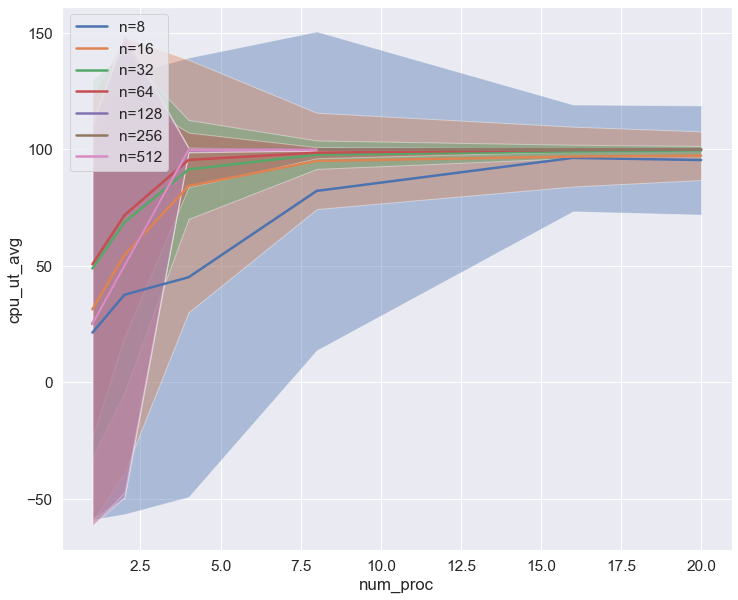

In [19]:
sns.set(font_scale=1.4)
ax = m5xlarge[m5xlarge.size_arr == 8].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
m5xlarge[m5xlarge.size_arr == 16].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
m5xlarge[m5xlarge.size_arr == 32].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
m5xlarge[m5xlarge.size_arr == 64].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
m5xlarge[m5xlarge.size_arr == 128].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")
m5xlarge[m5xlarge.size_arr == 256].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=256")
m5xlarge[m5xlarge.size_arr == 512].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=512")

ax.fill_between(m5xlarge[m5xlarge.size_arr == 8]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 8]['cpu_ut_avg']+2*m5xlarge[m5xlarge.size_arr == 8]['cpu_ut_std'], 
                m5xlarge[m5xlarge.size_arr == 8]['cpu_ut_avg']-2*m5xlarge[m5xlarge.size_arr == 8]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5xlarge[m5xlarge.size_arr == 16]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 16]['cpu_ut_avg']+2*m5xlarge[m5xlarge.size_arr == 16]['cpu_ut_std'], 
                m5xlarge[m5xlarge.size_arr == 16]['cpu_ut_avg']-2*m5xlarge[m5xlarge.size_arr == 16]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5xlarge[m5xlarge.size_arr == 32]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 32]['cpu_ut_avg']+2*m5xlarge[m5xlarge.size_arr == 32]['cpu_ut_std'], 
                m5xlarge[m5xlarge.size_arr == 32]['cpu_ut_avg']-2*m5xlarge[m5xlarge.size_arr == 32]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5xlarge[m5xlarge.size_arr == 64]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 64]['cpu_ut_avg']+2*m5xlarge[m5xlarge.size_arr == 64]['cpu_ut_std'], 
                m5xlarge[m5xlarge.size_arr == 64]['cpu_ut_avg']-2*m5xlarge[m5xlarge.size_arr == 64]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5xlarge[m5xlarge.size_arr == 128]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 128]['cpu_ut_avg']+2*m5xlarge[m5xlarge.size_arr == 128]['cpu_ut_std'], 
                m5xlarge[m5xlarge.size_arr == 128]['cpu_ut_avg']-2*m5xlarge[m5xlarge.size_arr == 128]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5xlarge[m5xlarge.size_arr == 256]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 256]['cpu_ut_avg']+2*m5xlarge[m5xlarge.size_arr == 256]['cpu_ut_std'], 
                m5xlarge[m5xlarge.size_arr == 256]['cpu_ut_avg']-2*m5xlarge[m5xlarge.size_arr == 256]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5xlarge[m5xlarge.size_arr == 512]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 512]['cpu_ut_avg']+2*m5xlarge[m5xlarge.size_arr == 512]['cpu_ut_std'], 
                m5xlarge[m5xlarge.size_arr == 512]['cpu_ut_avg']-2*m5xlarge[m5xlarge.size_arr == 512]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("cpu_ut_avg")

Text(0, 0.5, 'cpu_ut_avg')

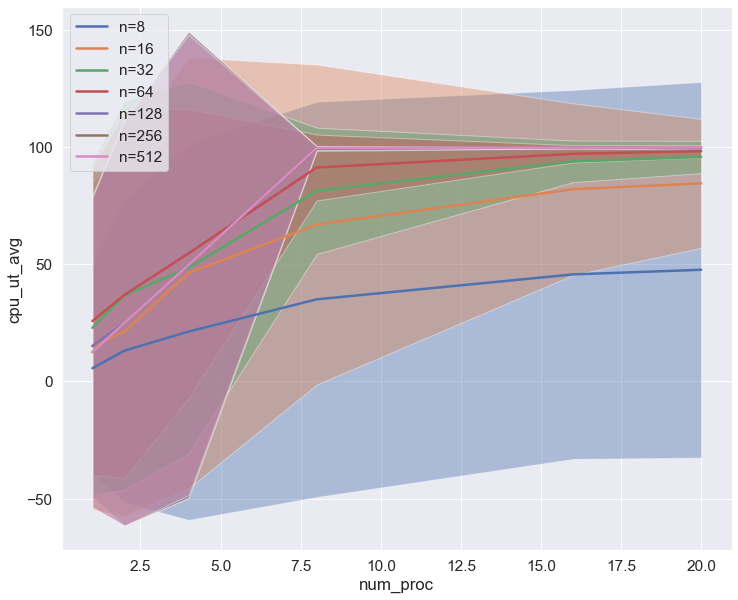

In [20]:
sns.set(font_scale=1.4)
ax = m52xlarge[m52xlarge.size_arr == 8].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
m52xlarge[m52xlarge.size_arr == 16].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
m52xlarge[m52xlarge.size_arr == 32].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
m52xlarge[m52xlarge.size_arr == 64].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
m52xlarge[m52xlarge.size_arr == 128].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")
m52xlarge[m52xlarge.size_arr == 256].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=256")
m52xlarge[m52xlarge.size_arr == 512].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=512")

ax.fill_between(m52xlarge[m52xlarge.size_arr == 8]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 8]['cpu_ut_avg']+2*m52xlarge[m52xlarge.size_arr == 8]['cpu_ut_std'], 
                m52xlarge[m52xlarge.size_arr == 8]['cpu_ut_avg']-2*m52xlarge[m52xlarge.size_arr == 8]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m52xlarge[m52xlarge.size_arr == 16]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 16]['cpu_ut_avg']+2*m52xlarge[m52xlarge.size_arr == 16]['cpu_ut_std'], 
                m52xlarge[m52xlarge.size_arr == 16]['cpu_ut_avg']-2*m52xlarge[m52xlarge.size_arr == 16]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m52xlarge[m52xlarge.size_arr == 32]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 32]['cpu_ut_avg']+2*m52xlarge[m52xlarge.size_arr == 32]['cpu_ut_std'], 
                m52xlarge[m52xlarge.size_arr == 32]['cpu_ut_avg']-2*m52xlarge[m52xlarge.size_arr == 32]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m52xlarge[m52xlarge.size_arr == 64]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 64]['cpu_ut_avg']+2*m52xlarge[m52xlarge.size_arr == 64]['cpu_ut_std'], 
                m52xlarge[m52xlarge.size_arr == 64]['cpu_ut_avg']-2*m52xlarge[m52xlarge.size_arr == 64]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m52xlarge[m52xlarge.size_arr == 128]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 128]['cpu_ut_avg']+2*m52xlarge[m52xlarge.size_arr == 128]['cpu_ut_std'], 
                m52xlarge[m52xlarge.size_arr == 128]['cpu_ut_avg']-2*m52xlarge[m52xlarge.size_arr == 128]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m52xlarge[m52xlarge.size_arr == 256]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 256]['cpu_ut_avg']+2*m52xlarge[m52xlarge.size_arr == 256]['cpu_ut_std'], 
                m52xlarge[m52xlarge.size_arr == 256]['cpu_ut_avg']-2*m52xlarge[m52xlarge.size_arr == 256]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m52xlarge[m52xlarge.size_arr == 512]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 512]['cpu_ut_avg']+2*m52xlarge[m52xlarge.size_arr == 512]['cpu_ut_std'], 
                m52xlarge[m52xlarge.size_arr == 512]['cpu_ut_avg']-2*m52xlarge[m52xlarge.size_arr == 512]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)


ax.legend()
ax.set_ylabel("cpu_ut_avg")

Text(0, 0.5, 'cpu_ut_avg')

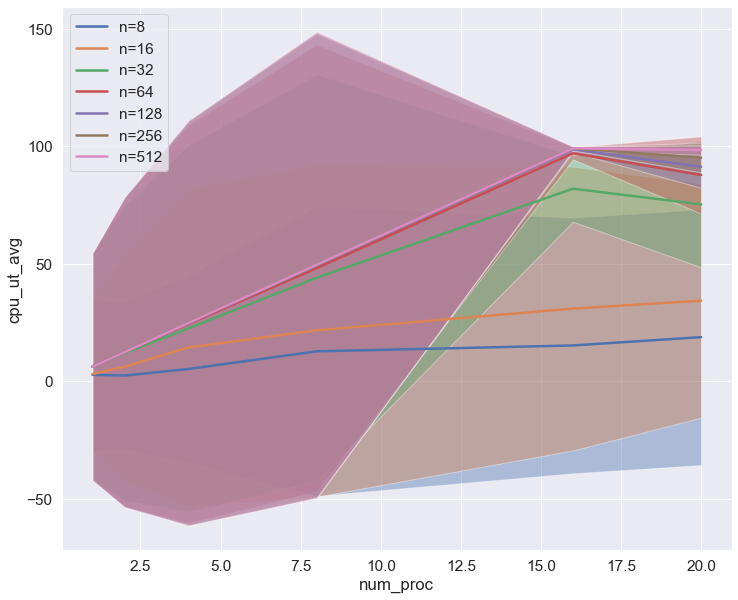

In [21]:
sns.set(font_scale=1.4)
ax = m54xlarge[m54xlarge.size_arr == 8].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
m54xlarge[m54xlarge.size_arr == 16].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
m54xlarge[m54xlarge.size_arr == 32].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
m54xlarge[m54xlarge.size_arr == 64].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
m54xlarge[m54xlarge.size_arr == 128].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")
m54xlarge[m54xlarge.size_arr == 256].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=256")
m54xlarge[m54xlarge.size_arr == 512].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=512")

ax.fill_between(m54xlarge[m54xlarge.size_arr == 8]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 8]['cpu_ut_avg']+2*m54xlarge[m54xlarge.size_arr == 8]['cpu_ut_std'], 
                m54xlarge[m54xlarge.size_arr == 8]['cpu_ut_avg']-2*m54xlarge[m54xlarge.size_arr == 8]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 16]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 16]['cpu_ut_avg']+2*m54xlarge[m54xlarge.size_arr == 16]['cpu_ut_std'], 
                m54xlarge[m54xlarge.size_arr == 16]['cpu_ut_avg']-2*m54xlarge[m54xlarge.size_arr == 16]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 32]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 32]['cpu_ut_avg']+2*m54xlarge[m54xlarge.size_arr == 32]['cpu_ut_std'], 
                m54xlarge[m54xlarge.size_arr == 32]['cpu_ut_avg']-2*m54xlarge[m54xlarge.size_arr == 32]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 64]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 64]['cpu_ut_avg']+2*m54xlarge[m54xlarge.size_arr == 64]['cpu_ut_std'], 
                m54xlarge[m54xlarge.size_arr == 64]['cpu_ut_avg']-2*m54xlarge[m54xlarge.size_arr == 64]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 128]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 128]['cpu_ut_avg']+2*m54xlarge[m54xlarge.size_arr == 128]['cpu_ut_std'], 
                m54xlarge[m54xlarge.size_arr == 128]['cpu_ut_avg']-2*m54xlarge[m54xlarge.size_arr == 128]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 256]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 256]['cpu_ut_avg']+2*m54xlarge[m54xlarge.size_arr == 256]['cpu_ut_std'], 
                m54xlarge[m54xlarge.size_arr == 256]['cpu_ut_avg']-2*m54xlarge[m54xlarge.size_arr == 256]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 512]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 512]['cpu_ut_avg']+2*m54xlarge[m54xlarge.size_arr == 512]['cpu_ut_std'], 
                m54xlarge[m54xlarge.size_arr == 512]['cpu_ut_avg']-2*m54xlarge[m54xlarge.size_arr == 512]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("cpu_ut_avg")

Text(0, 0.5, 'cpu_ut_avg')

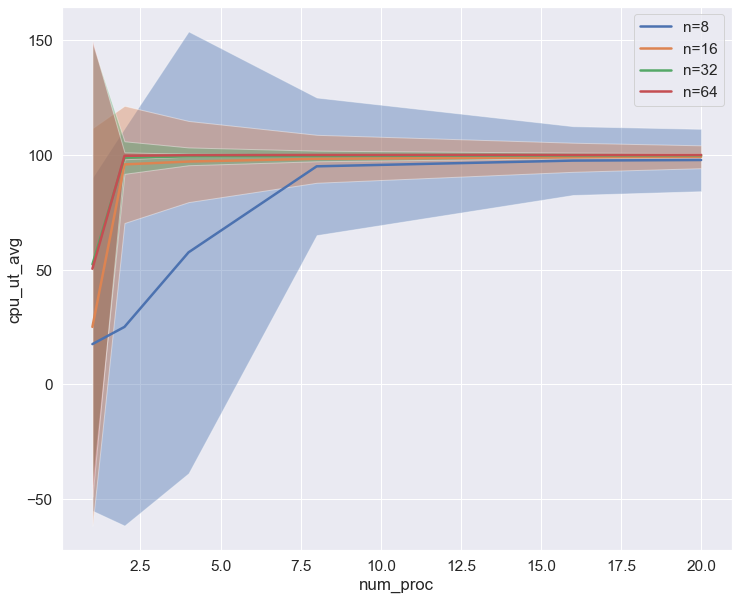

In [22]:
sns.set(font_scale=1.4)
ax = r5large[r5large.size_arr == 8].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
r5large[r5large.size_arr == 16].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
r5large[r5large.size_arr == 32].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
r5large[r5large.size_arr == 64].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")

ax.fill_between(r5large[r5large.size_arr == 8]['num_proc'], 
                r5large[r5large.size_arr == 8]['cpu_ut_avg']+2*r5large[r5large.size_arr == 8]['cpu_ut_std'], 
                r5large[r5large.size_arr == 8]['cpu_ut_avg']-2*r5large[r5large.size_arr == 8]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5large[r5large.size_arr == 16]['num_proc'], 
                r5large[r5large.size_arr == 16]['cpu_ut_avg']+2*r5large[r5large.size_arr == 16]['cpu_ut_std'], 
                r5large[r5large.size_arr == 16]['cpu_ut_avg']-2*r5large[r5large.size_arr == 16]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5large[r5large.size_arr == 32]['num_proc'], 
                r5large[r5large.size_arr == 32]['cpu_ut_avg']+2*r5large[r5large.size_arr == 32]['cpu_ut_std'], 
                r5large[r5large.size_arr == 32]['cpu_ut_avg']-2*r5large[r5large.size_arr == 32]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5large[r5large.size_arr == 64]['num_proc'], 
                r5large[r5large.size_arr == 64]['cpu_ut_avg']+2*r5large[r5large.size_arr == 64]['cpu_ut_std'], 
                r5large[r5large.size_arr == 64]['cpu_ut_avg']-2*r5large[r5large.size_arr == 64]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("cpu_ut_avg")

Text(0, 0.5, 'cpu_ut_avg')

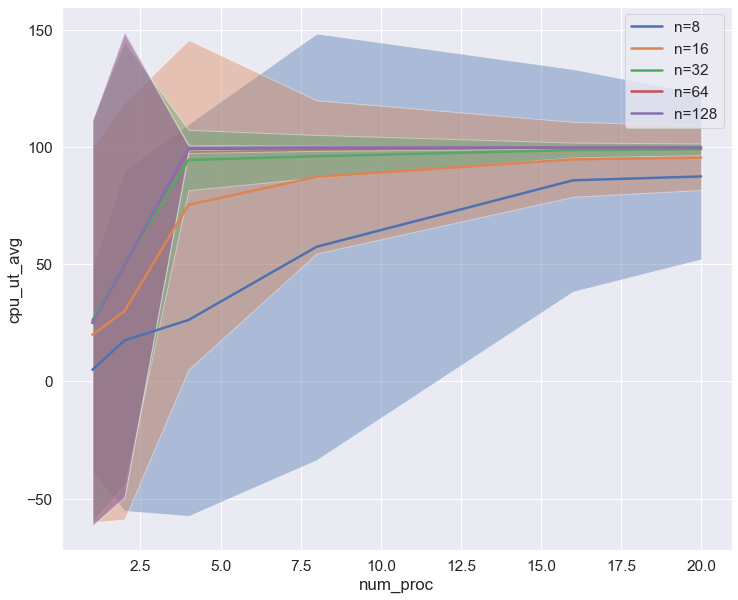

In [23]:
sns.set(font_scale=1.4)
ax = r5xlarge[r5xlarge.size_arr == 8].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
r5xlarge[r5xlarge.size_arr == 16].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
r5xlarge[r5xlarge.size_arr == 32].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
r5xlarge[r5xlarge.size_arr == 64].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
r5xlarge[r5xlarge.size_arr == 128].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")

ax.fill_between(r5xlarge[r5xlarge.size_arr == 8]['num_proc'], 
                r5xlarge[r5xlarge.size_arr == 8]['cpu_ut_avg']+2*r5xlarge[r5xlarge.size_arr == 8]['cpu_ut_std'], 
                r5xlarge[r5xlarge.size_arr == 8]['cpu_ut_avg']-2*r5xlarge[r5xlarge.size_arr == 8]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5xlarge[r5xlarge.size_arr == 16]['num_proc'], 
                r5xlarge[r5xlarge.size_arr == 16]['cpu_ut_avg']+2*r5xlarge[r5xlarge.size_arr == 16]['cpu_ut_std'], 
                r5xlarge[r5xlarge.size_arr == 16]['cpu_ut_avg']-2*r5xlarge[r5xlarge.size_arr == 16]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5xlarge[r5xlarge.size_arr == 32]['num_proc'], 
                r5xlarge[r5xlarge.size_arr == 32]['cpu_ut_avg']+2*r5xlarge[r5xlarge.size_arr == 32]['cpu_ut_std'], 
                r5xlarge[r5xlarge.size_arr == 32]['cpu_ut_avg']-2*r5xlarge[r5xlarge.size_arr == 32]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5xlarge[r5xlarge.size_arr == 64]['num_proc'], 
                r5xlarge[r5xlarge.size_arr == 64]['cpu_ut_avg']+2*r5xlarge[r5xlarge.size_arr == 64]['cpu_ut_std'], 
                r5xlarge[r5xlarge.size_arr == 64]['cpu_ut_avg']-2*r5xlarge[r5xlarge.size_arr == 64]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5xlarge[r5xlarge.size_arr == 128]['num_proc'], 
                r5xlarge[r5xlarge.size_arr == 128]['cpu_ut_avg']+2*r5xlarge[r5xlarge.size_arr == 128]['cpu_ut_std'], 
                r5xlarge[r5xlarge.size_arr == 128]['cpu_ut_avg']-2*r5xlarge[r5xlarge.size_arr == 128]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("cpu_ut_avg")

Text(0, 0.5, 'cpu_ut_avg')

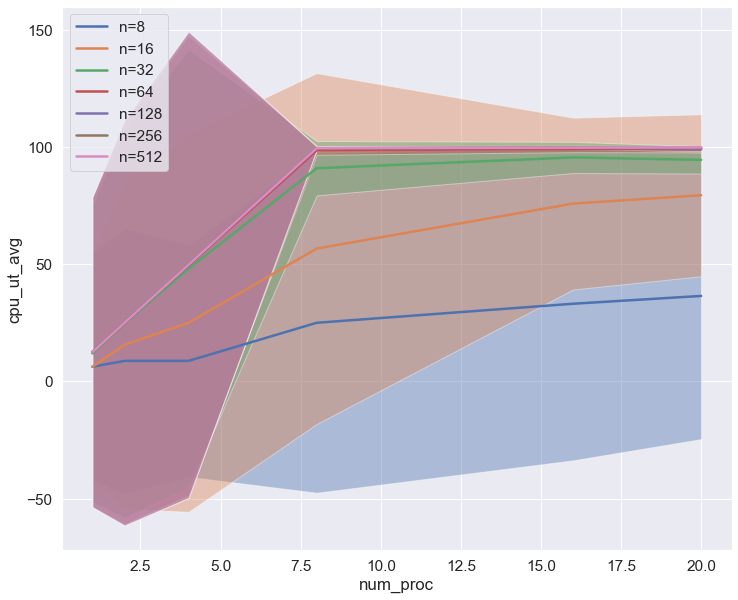

In [24]:
sns.set(font_scale=1.4)
ax = r52xlarge[r52xlarge.size_arr == 8].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
r52xlarge[r52xlarge.size_arr == 16].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
r52xlarge[r52xlarge.size_arr == 32].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
r52xlarge[r52xlarge.size_arr == 64].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
r52xlarge[r52xlarge.size_arr == 128].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")
r52xlarge[r52xlarge.size_arr == 256].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=256")
r52xlarge[r52xlarge.size_arr == 512].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=512")

ax.fill_between(r52xlarge[r52xlarge.size_arr == 8]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 8]['cpu_ut_avg']+2*r52xlarge[r52xlarge.size_arr == 8]['cpu_ut_std'], 
                r52xlarge[r52xlarge.size_arr == 8]['cpu_ut_avg']-2*r52xlarge[r52xlarge.size_arr == 8]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r52xlarge[r52xlarge.size_arr == 16]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 16]['cpu_ut_avg']+2*r52xlarge[r52xlarge.size_arr == 16]['cpu_ut_std'], 
                r52xlarge[r52xlarge.size_arr == 16]['cpu_ut_avg']-2*r52xlarge[r52xlarge.size_arr == 16]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r52xlarge[r52xlarge.size_arr == 32]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 32]['cpu_ut_avg']+2*r52xlarge[r52xlarge.size_arr == 32]['cpu_ut_std'], 
                r52xlarge[r52xlarge.size_arr == 32]['cpu_ut_avg']-2*r52xlarge[r52xlarge.size_arr == 32]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r52xlarge[r52xlarge.size_arr == 64]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 64]['cpu_ut_avg']+2*r52xlarge[r52xlarge.size_arr == 64]['cpu_ut_std'], 
                r52xlarge[r52xlarge.size_arr == 64]['cpu_ut_avg']-2*r52xlarge[r52xlarge.size_arr == 64]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r52xlarge[r52xlarge.size_arr == 128]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 128]['cpu_ut_avg']+2*r52xlarge[r52xlarge.size_arr == 128]['cpu_ut_std'], 
                r52xlarge[r52xlarge.size_arr == 128]['cpu_ut_avg']-2*r52xlarge[r52xlarge.size_arr == 128]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r52xlarge[r52xlarge.size_arr == 256]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 256]['cpu_ut_avg']+2*r52xlarge[r52xlarge.size_arr == 256]['cpu_ut_std'], 
                r52xlarge[r52xlarge.size_arr == 256]['cpu_ut_avg']-2*r52xlarge[r52xlarge.size_arr == 256]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r52xlarge[r52xlarge.size_arr == 512]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 512]['cpu_ut_avg']+2*r52xlarge[r52xlarge.size_arr == 512]['cpu_ut_std'], 
                r52xlarge[r52xlarge.size_arr == 512]['cpu_ut_avg']-2*r52xlarge[r52xlarge.size_arr == 512]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("cpu_ut_avg")

Text(0, 0.5, 'cpu_ut_avg')

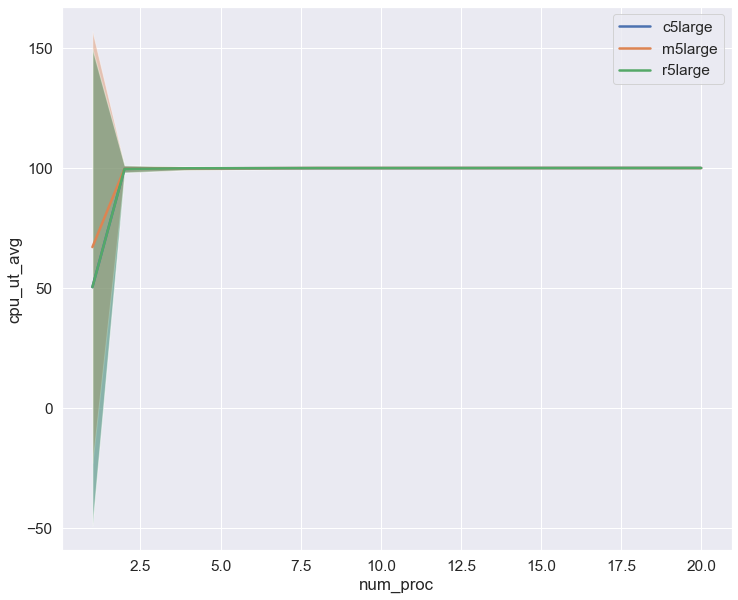

In [25]:
import seaborn as sns
import matplotlib as plt

sns.set(font_scale=1.4)
ax = c5large[c5large.size_arr == 64].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="c5large")
m5large[m5large.size_arr == 64].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="m5large")
r5large[r5large.size_arr == 64].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="r5large")

ax.fill_between(c5large[c5large.size_arr == 64]['num_proc'], 
                c5large[c5large.size_arr == 64]['cpu_ut_avg']+2*c5large[c5large.size_arr == 64]['cpu_ut_std'], 
                c5large[c5large.size_arr == 64]['cpu_ut_avg']-2*c5large[c5large.size_arr == 64]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5large[m5large.size_arr == 64]['num_proc'], 
                m5large[m5large.size_arr == 64]['cpu_ut_avg']+2*m5large[m5large.size_arr == 64]['cpu_ut_std'], 
                m5large[m5large.size_arr == 64]['cpu_ut_avg']-2*m5large[m5large.size_arr == 64]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5large[r5large.size_arr == 64]['num_proc'], 
                r5large[r5large.size_arr == 64]['cpu_ut_avg']+2*r5large[r5large.size_arr == 64]['cpu_ut_std'], 
                r5large[r5large.size_arr == 64]['cpu_ut_avg']-2*r5large[r5large.size_arr == 64]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("cpu_ut_avg")

Text(0, 0.5, 'cpu_ut_avg')

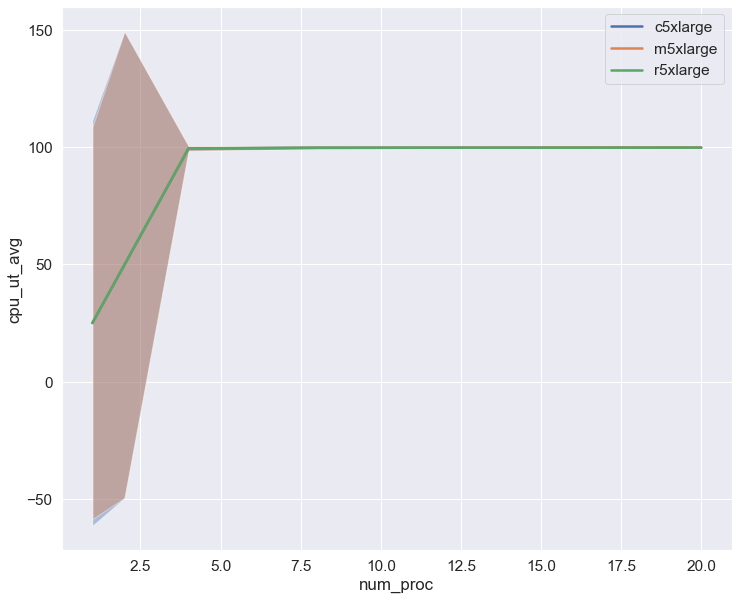

In [27]:
sns.set(font_scale=1.4)
ax = c5xlarge[c5xlarge.size_arr == 128].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="c5xlarge")
m5xlarge[m5xlarge.size_arr == 128].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="m5xlarge")
r5xlarge[r5xlarge.size_arr == 128].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="r5xlarge")

ax.fill_between(c5xlarge[c5xlarge.size_arr == 128]['num_proc'], 
                c5xlarge[c5xlarge.size_arr == 128]['cpu_ut_avg']+2*c5xlarge[c5xlarge.size_arr == 128]['cpu_ut_std'], 
                c5xlarge[c5xlarge.size_arr == 128]['cpu_ut_avg']-2*c5xlarge[c5xlarge.size_arr == 128]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m5xlarge[m5xlarge.size_arr == 128]['num_proc'], 
                m5xlarge[m5xlarge.size_arr == 128]['cpu_ut_avg']+2*m5xlarge[m5xlarge.size_arr == 128]['cpu_ut_std'], 
                m5xlarge[m5xlarge.size_arr == 128]['cpu_ut_avg']-2*m5xlarge[m5xlarge.size_arr == 128]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r5xlarge[r5xlarge.size_arr == 128]['num_proc'], 
                r5xlarge[r5xlarge.size_arr == 128]['cpu_ut_avg']+2*r5xlarge[r5xlarge.size_arr == 128]['cpu_ut_std'], 
                r5xlarge[r5xlarge.size_arr == 128]['cpu_ut_avg']-2*r5xlarge[r5xlarge.size_arr == 128]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("cpu_ut_avg")

Text(0, 0.5, 'time_avg')

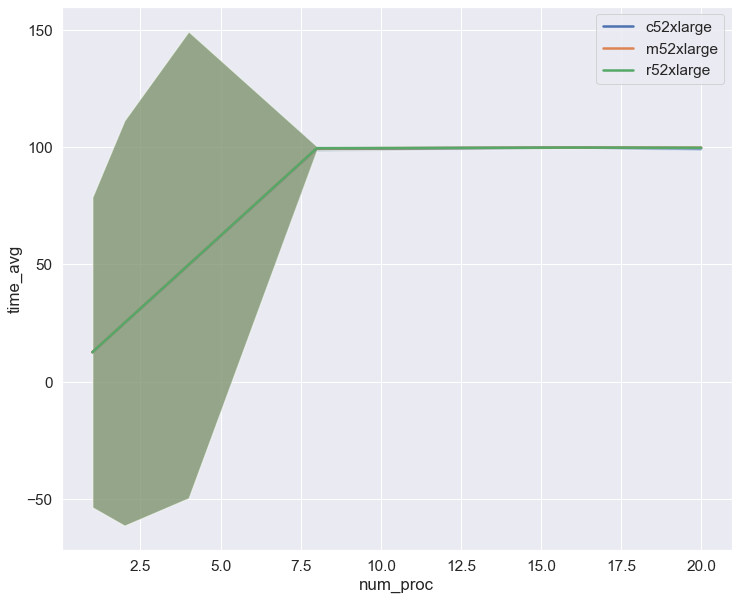

In [28]:
sns.set(font_scale=1.4)
ax = c52xlarge[c52xlarge.size_arr == 256].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="c52xlarge")
m52xlarge[m52xlarge.size_arr == 256].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="m52xlarge")
r52xlarge[r52xlarge.size_arr == 256].set_index('num_proc')['cpu_ut_avg'].plot(figsize=(12, 10), linewidth=2.5, label="r52xlarge")

ax.fill_between(c52xlarge[c52xlarge.size_arr == 256]['num_proc'], 
                c52xlarge[c52xlarge.size_arr == 256]['cpu_ut_avg']+2*c52xlarge[c52xlarge.size_arr == 256]['cpu_ut_std'], 
                c52xlarge[c52xlarge.size_arr == 256]['cpu_ut_avg']-2*c52xlarge[c52xlarge.size_arr == 256]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m52xlarge[m52xlarge.size_arr == 256]['num_proc'], 
                m52xlarge[m52xlarge.size_arr == 256]['cpu_ut_avg']+2*m52xlarge[m52xlarge.size_arr == 256]['cpu_ut_std'], 
                m52xlarge[m52xlarge.size_arr == 256]['cpu_ut_avg']-2*m52xlarge[m52xlarge.size_arr == 256]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(r52xlarge[r52xlarge.size_arr == 256]['num_proc'], 
                r52xlarge[r52xlarge.size_arr == 256]['cpu_ut_avg']+2*r52xlarge[r52xlarge.size_arr == 256]['cpu_ut_std'], 
                r52xlarge[r52xlarge.size_arr == 256]['cpu_ut_avg']-2*r52xlarge[r52xlarge.size_arr == 256]['cpu_ut_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
ax.set_ylabel("time_avg")